# CIFAR10 with CNNs

Scores do modelo original:

 {'accuracy': 0.7136, 'balanced_accuracy': np.float64(0.7136000000000001), 'precision': 0.7141355730287995, 'recall': 0.7136, 'f1_score': 0.7133133029149751}

In [33]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

In [34]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [35]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,  transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,  transform=transform)

classes = test_dataset.classes

Gera val_dataset como subset balanceado de train_val_dataset


In [36]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

## Visualizar imagens

In [37]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [38]:
# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

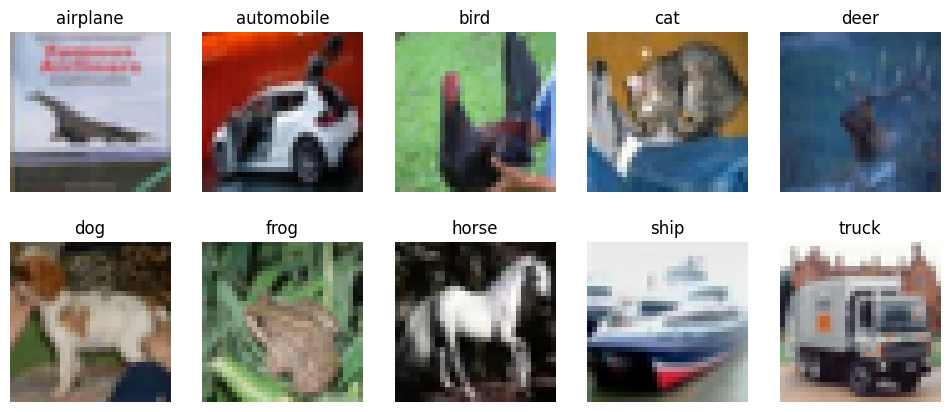

In [39]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

### Defining the CNN model
Here we adapt the LeNet-5 architecture introduced in [*Gradient-based learning applied to document recognition*](https://ieeexplore.ieee.org/document/726791), originally developed to classify handwritten digits.

![lenet5](https://www.researchgate.net/publication/359784095/figure/fig2/AS:11431281079624737@1660789284522/Example-of-a-CNN-LeNet-5-14-is-able-to-identify-handwritten-digits-for-zip-code.png)


The main change we made here is the number of in/out channels, kernel sizes, padding, etc (enabling better results). It has 2 convolutional layers followed by 2 pooling (subsampling) layers. After the conv. blocks, we pass the feature maps through 2 hidden fully-connected layers to get the most activated neuron with the softmax function. If you want a more detailed explanation, [check this link](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/) or reach us on Discord :)

In [40]:
class FlexibleCNN(nn.Module):
    """
    Uma classe de CNN flexível com entrada para imagens de 3 canais e 32x32 pixels.
    """
    def __init__(self, config):
        super(FlexibleCNN, self).__init__()
        self.config = config

        # Valores de entrada fixos
        initial_in_channels = 3
        img_height = 32
        img_width = 32

        # 1. Camadas de extração de características
        features_layers = []
        in_channels = initial_in_channels # Começa com o valor inicial

        for out_channels, k, s, p in self.config['conv_layers']:
            features_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=k,
                    stride=s,
                    padding=p
                )
            )
            features_layers.append(nn.ReLU())
            if self.config.get('pool_kernel_size'):
                features_layers.append(
                    nn.MaxPool2d(
                        kernel_size=self.config['pool_kernel_size'],
                        stride=self.config.get('pool_stride', self.config['pool_kernel_size'])
                    )
                )
            in_channels = out_channels # Atualiza para a próxima camada do loop

        self.features = nn.Sequential(*features_layers)

        # 2. Calcular o tamanho da saída do extrator de features
        with torch.no_grad():
            dummy_input = torch.zeros(1, initial_in_channels, img_height, img_width)
            dummy_output = self.features(dummy_input)
            self.flattened_features_size = dummy_output.view(-1).shape[0]

        # 3. Construir o Classificador 
        classifier_layers = []
        in_features = self.flattened_features_size

        for out_features, dropout_rate in self.config.get('fc_layers', []):
            classifier_layers.append(nn.Linear(in_features, out_features))
            classifier_layers.append(nn.ReLU())
            if dropout_rate > 0:
                classifier_layers.append(nn.Dropout(p=dropout_rate))
            in_features = out_features

        classifier_layers.append(nn.Linear(in_features, self.config['output_size']))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        # O assert foi removido para simplificar, mas pode ser útil para debug
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Evaluation helper functions

In [41]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [42]:
def evaluate(net, loader, loss_function):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [43]:
#@title Evaluate model (accuracy, precision, recall, etc)

def makePredictions(net, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

In [44]:
def plotLoss(train_losses, val_losses):
    plt.plot(train_losses, label='Treinamento')
    plt.plot(val_losses, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

## Train Loop

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses

## Experiment 1

In [46]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5

In [47]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model1 = FlexibleCNN(config1)

In [49]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trained_CNN, train_losses, val_losses = train_model(model1,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:11<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.1156


  0%|          | 0/50 [00:17<?, ?it/s]


KeyboardInterrupt: 

## Experiment 1 results

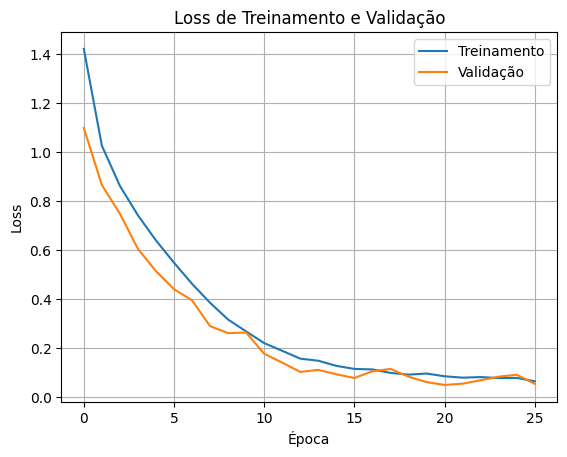

In [24]:
plotLoss(train_losses, val_losses)

In [25]:
torch.save(model1.state_dict(), "model1_trained2.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = FlexibleCNN(config1)
model1.to(device)

model1.load_state_dict(torch.load("model1_trained.pth", weights_only=True))

<All keys matched successfully>

In [27]:
#@title Evaluate model (accuracy, precision, recall, etc)
labels, predictions = makePredictions(model1, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


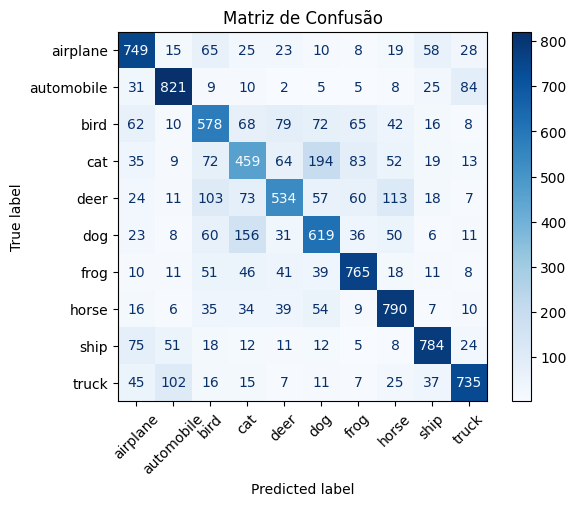

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Mostrar exemplos classificados corretamente e incorretamente

In [50]:
# Função para desnormalizar e exibir em um subplot (sem plt.show())
def imshow_subplot(ax, img_tensor, title=""):
    img = img_tensor.cpu().numpy()
    # Desnormaliza a imagem
    img = img / 2 + 0.5
    # Converte de (C, H, W) para (H, W, C) para o matplotlib
    img = np.transpose(img, (1, 2, 0))
    
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

Encontradas 5 imagens corretas e 5 imagens incorretas.


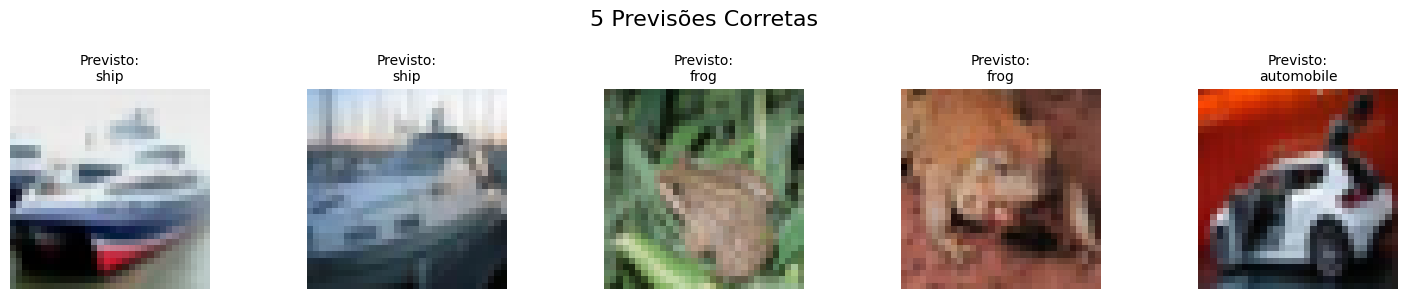

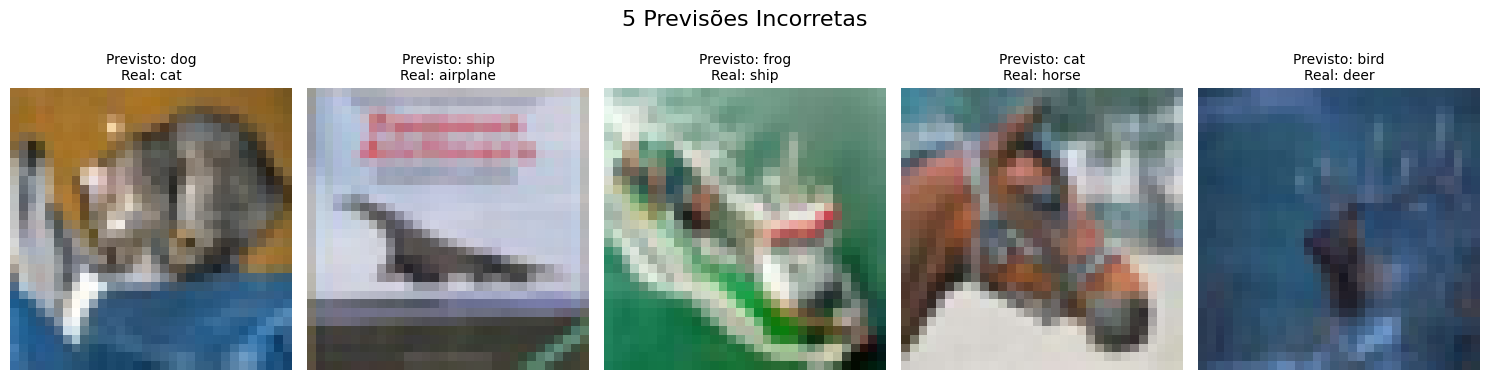

In [51]:
# Listas para armazenar os resultados
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []

model1.eval()

# Loop para encontrar as imagens
with torch.no_grad():
    # Itera sobre o loader de teste
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        _, preds = torch.max(outputs, 1)

        # Itera sobre o batch
        for i in range(len(labels)):
            if preds[i] == labels[i] and len(correct_images) < 5:
                correct_images.append(images[i].cpu())
                correct_labels.append(preds[i].cpu())

            # Se a previsão está incorreta E ainda não temos 5
            elif preds[i] != labels[i] and len(incorrect_images) < 5:
                incorrect_images.append(images[i].cpu())
                incorrect_true_labels.append(labels[i].cpu())
                incorrect_pred_labels.append(preds[i].cpu())

            # Condição de parada: para quando ambas as listas estiverem cheias
            if len(correct_images) == 5 and len(incorrect_images) == 5:
                break
        
        # Para o loop principal também
        if len(correct_images) == 5 and len(incorrect_images) == 5:
            break

print(f"Encontradas {len(correct_images)} imagens corretas e {len(incorrect_images)} imagens incorretas.")


# Exibe as 5 previsões corretas
fig_correct, axes_correct = plt.subplots(1, 5, figsize=(15, 3))
fig_correct.suptitle("5 Previsões Corretas", fontsize=16)

for i, ax in enumerate(axes_correct):
    if i < len(correct_images):
        title = f"Previsto:\n{class_names[correct_labels[i].item()]}"
        imshow_subplot(ax, correct_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta para o super-título
plt.show()


# Exibe as 5 previsões incorretas
fig_incorrect, axes_incorrect = plt.subplots(1, 5, figsize=(15, 4)) # Um pouco mais de altura para o título duplo
fig_incorrect.suptitle("5 Previsões Incorretas", fontsize=16)

for i, ax in enumerate(axes_incorrect):
    if i < len(incorrect_images):
        title = f"Previsto: {class_names[incorrect_pred_labels[i].item()]}\nReal: {class_names[incorrect_true_labels[i].item()]}"
        imshow_subplot(ax, incorrect_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()